<a href="https://colab.research.google.com/github/panzershracker/Deep-learning-in-comp.-vision/blob/master/HW_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Домашнее задание. 7 Урок. Евдокимов Алексей

# Задание

Обучить нейронную сеть для распознавания действий человека по видео на датасете KTH
Библиотеки: [Python, Tensorflow]

#! На данный момент модель предсказывает все как 'running', так же loss остается неизменным на протяжении всех 10-ти эпох. Пытаюсь разобраться.

In [45]:
%tensorflow_version 2.x

In [46]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [47]:
tf.__version__

'2.2.0'

In [48]:
install = 1

if install:
  !pip install scikit-video

import skvideo.io

In [49]:
# !rm -rf walking
# !rm -rf jogging
# !rm -rf running
# !rm -rf boxing
# !rm -rf handwaving
# !rm -rf handclapping

In [50]:
# if install:
#     !wget http://www.nada.kth.se/cvap/actions/walking.zip
#     !wget http://www.nada.kth.se/cvap/actions/jogging.zip
#     !wget http://www.nada.kth.se/cvap/actions/running.zip
#     !wget http://www.nada.kth.se/cvap/actions/boxing.zip
#     !wget http://www.nada.kth.se/cvap/actions/handwaving.zip
#     !wget http://www.nada.kth.se/cvap/actions/handclapping.zip 

if install:
    !unzip walking.zip -d walking > /dev/null
    !unzip jogging.zip -d jogging > /dev/null
    !unzip running.zip -d running > /dev/null
    !unzip boxing.zip -d boxing > /dev/null
    !unzip handwaving.zip -d handwaving > /dev/null
    !unzip handclapping.zip -d handclapping > /dev/null

In [51]:
classes = [
    'walking',
    'jogging',
    'running',
    'boxing',
    'handwaving',
    'handclapping',
]

In [52]:
dataset = []
data_root = './'

for cls in classes:
  print('Class: {}'.format(cls))
  for fpath in glob.glob(os.path.join(data_root, cls, '*.avi')):
    cls_idx = classes.index(cls)
    dataset.append((fpath, cls_idx))

Class: walking
Class: jogging
Class: running
Class: boxing
Class: handwaving
Class: handclapping


In [53]:
len(dataset)

599

Посмотрим кол-во образцов по каждому классу

In [54]:
from collections import Counter

In [55]:
cls_counts = Counter([elem[1] for elem in dataset])
cls_counts

Counter({0: 100, 1: 100, 2: 100, 3: 100, 4: 100, 5: 99})

#Разделим датасет на тренировочную и тестовую части

In [56]:
# 60 произвольных элементов для тестовой выборки
test = random.sample(dataset, 60) 

# Удалим тестовые значения из основного датасета.
for i in test:
  dataset.remove(i)

random.shuffle(test)

In [57]:
len(dataset)

539

#Визуализация кадра из видео

shape (636, 120, 160, 3)


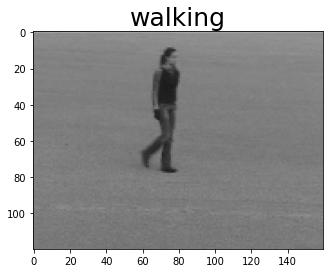

In [58]:
videodata = skvideo.io.vread(dataset[0][0])
videodata = videodata.astype(np.float32) / 255
print(f'shape {videodata.shape}')
plt.imshow(videodata[50, ...])

plt.title(classes[dataset[0][1]], fontsize=25)
plt.show()

#Визуализация движения

Shape (635, 120, 160, 1)


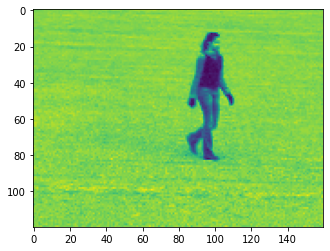

In [59]:
motion = np.mean(videodata[1:, ...] - videodata[-1:, ...], axis=3, keepdims=True)
print(f'Shape {motion.shape}')

plt.imshow(motion[60, ..., 0])

plt.show()

# Создание модели (CNN)

In [60]:
model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(32, (5,5,5), (1,2,2), padding='same', activation='relu'),
        tf.keras.layers.MaxPool3D((1,2,2), padding='same'),
        tf.keras.layers.Conv3D(64, (5,5,5), (1,2,2), padding='same', activation='relu'),
        tf.keras.layers.MaxPool3D((1,2,2), padding='same'),
        tf.keras.layers.Conv3D(64, (5,5,5), (1,2,2), padding='same', activation='relu'),
        tf.keras.layers.MaxPool3D((1,2,2), padding='same'),
        tf.keras.layers.Conv3D(64, (3,3,3), (1,2,2), padding='same', activation=None),
        tf.keras.layers.GlobalAveragePooling3D(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(6, activation=None)
])

In [61]:
inp = motion[None, ...]
out = model(inp)

print(f'inp shape {inp.shape}')
print(f'out shape {out.shape}')

inp shape (1, 635, 120, 160, 1)
out shape (1, 6)


# Подготовка к обучению

In [62]:
EPOCHS = 5
LEARNING_RATE = 0.0005

model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(LEARNING_RATE))

writer = tf.summary.create_file_writer('logs/test_1')

#Цикл обучения

In [63]:
%%time

global_step = 0

for epoch in range(EPOCHS):
  for iter, (fpath, label) in enumerate(dataset):
    videodata = skvideo.io.vread(fpath)
    videodata = videodata.astype(np.float32) / 255
    motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)
    x = motion[None, ...]
    y = np.array(label)[None, ...]

    loss = model.train_on_batch(x, y)

    if iter % 10 == 0:
      print(f'epoch = {epoch}/{EPOCHS}, iter = {iter}/{len(dataset)}, loss = {loss}')

      with writer.as_default():
        tf.summary.scalar('loss', loss, global_step)

    global_step += 1

epoch = 0/5, iter = 0/539, loss = 1.792335033416748
epoch = 0/5, iter = 10/539, loss = 0.0
epoch = 0/5, iter = 20/539, loss = 0.0
epoch = 0/5, iter = 30/539, loss = 0.0
epoch = 0/5, iter = 40/539, loss = 0.0
epoch = 0/5, iter = 50/539, loss = 0.0
epoch = 0/5, iter = 60/539, loss = 0.0
epoch = 0/5, iter = 70/539, loss = 0.0
epoch = 0/5, iter = 80/539, loss = 0.0
epoch = 0/5, iter = 90/539, loss = 0.0
epoch = 0/5, iter = 100/539, loss = 1.8902206420898438
epoch = 0/5, iter = 110/539, loss = 1.7065109014511108
epoch = 0/5, iter = 120/539, loss = 1.5916078090667725
epoch = 0/5, iter = 130/539, loss = 1.4444091320037842
epoch = 0/5, iter = 140/539, loss = 1.2604790925979614
epoch = 0/5, iter = 150/539, loss = 1.047898769378662
epoch = 0/5, iter = 160/539, loss = 0.818742036819458
epoch = 0/5, iter = 170/539, loss = 0.5957837104797363
epoch = 0/5, iter = 180/539, loss = 2.9222378730773926
epoch = 0/5, iter = 190/539, loss = 2.7282586097717285
epoch = 0/5, iter = 200/539, loss = 2.33362793922

# TODO Разделить на тестовый и тренировочный датасеты

In [66]:
%load_ext tensorboard
%tensorboard --logdir logs

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 73880), started 2:48:15 ago. (Use '!kill 73880' to kill it.)

<IPython.core.display.Javascript object>

# Проверка на образце из тестового набора набора.

True class: jogging
Predicted class: handclapping


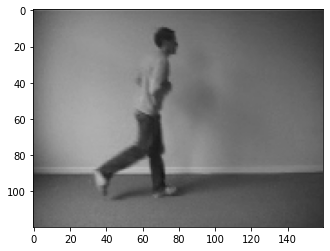

In [71]:
fpath, cls_true = random.choice(test)

videodata = skvideo.io.vread(fpath)
videodata = videodata.astype(np.float32) / 255.
plt.imshow(videodata[30, ...])

motion = np.mean(videodata[1:, ...] - videodata[:-1, ...], axis=3, keepdims=True)

out = model(motion[None, ...])[0]
cls_pred = np.argmax(out.numpy())

print('True class:', classes[cls_true])
print('Predicted class:', classes[cls_pred])

#TODO Сделать проверку и оценку по всем тестовым образцам.